# Visualize forcing before and after remapping


In [19]:
# modules
import os
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

#### Control file handling

In [3]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [4]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [5]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [6]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [7]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'geospatial_fields_remapping.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Find location the catchment shapefile

In [12]:
# HRU fieldname - this is the same for all three shapefiles
shp_hru = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

In [106]:
# Path & name
catchment_path = read_from_control(controlFolder/controlFile,'catchment_shp_path')
catchment_name = read_from_control(controlFolder/controlFile,'catchment_shp_name')

In [107]:
# Specify default path if needed
if catchment_path == 'default':
    catchment_path = make_default_path('shapefiles/catchment') # outputs a Path()
else:
    catchment_path = Path(catchment_path) # make sure a user-specified path is a Path()

#### Find location of source .tifs

In [15]:
# DEM path & name
dem_path = read_from_control(controlFolder/controlFile,'parameter_dem_tif_path')
dem_name = read_from_control(controlFolder/controlFile,'parameter_dem_tif_name')

# Specify default path if needed
if dem_path == 'default':
    dem_path = make_default_path('parameters/dem/5_elevation') # outputs a Path()
else:
    dem_path = Path(dem_path) # make sure a user-specified path is a Path()

In [16]:
# Soil path & name
soil_path = read_from_control(controlFolder/controlFile,'parameter_soil_domain_path')
soil_name = read_from_control(controlFolder/controlFile,'parameter_soil_tif_name')

# Specify default path if needed
if soil_path == 'default':
    soil_path = make_default_path('parameters/soilclass/2_soil_classes_domain') # outputs a Path()
else:
    soil_path = Path(soil_path) # make sure a user-specified path is a Path()

In [17]:
# Land path & name
land_path = read_from_control(controlFolder/controlFile,'parameter_land_mode_path')
land_name = read_from_control(controlFolder/controlFile,'parameter_land_tif_name')

# Specify default path if needed
if land_path == 'default':
    land_path = make_default_path('parameters/landclass/7_mode_land_class') # outputs a Path()
else:
    land_path = Path(land_path) # make sure a user-specified path is a Path()

#### Find location of the attributes file

In [96]:
# attributes path & name
att_path = read_from_control(controlFolder/controlFile,'settings_summa_path')
att_name = read_from_control(controlFolder/controlFile,'settings_summa_attributes')

In [97]:
# Specify default path if needed
if att_path == 'default':
    att_path = make_default_path('settings/SUMMA') # outputs a Path()
else:
    att_path = Path(att_path) # make sure a user-specified path is a Path()

#### Load the shapefiles and the data

In [108]:
# shapefile
catchment = gpd.read_file(catchment_path/catchment_name)

In [21]:
# tifs
dem = xr.open_rasterio(dem_path/dem_name)
soil = xr.open_rasterio(soil_path/soil_name)
land = xr.open_rasterio(land_path/land_name)

In [98]:
# attributes
att = xr.open_dataset(att_path/att_name)

#### Map attributes data to catchment HRUs

In [111]:
# Elevation
if (att['hruId'] == catchment[shp_hru]).all():
    catchment['plot_elev'] = att['elevation']
    catchment['plot_soil'] = att['soilTypeIndex']
    catchment['plot_land'] = att['vegTypeIndex']

#### Plot settings and plotting data prep

In [119]:
# Colors
cmap_dem = 'Greys_r'
cmap_soil = plt.get_cmap('YlOrBr').copy()
cmap_soil.set_under('w')
cmap_land = plt.get_cmap('Greens').copy()
cmap_land.set_under('w')

In [93]:
# color limits
vmin_dem,vmax_dem = dem.min(),dem.max()
vmin_soil,vmax_soil = 1,12 # hard-coded, there are this many classes
vmin_land,vmax_land = 1,17 # hard-coded, there are this many classes

In [117]:
# colorbar settings
ticks_soil = range(1,13)
ticks_land = range(1,18)

#### Create the figure

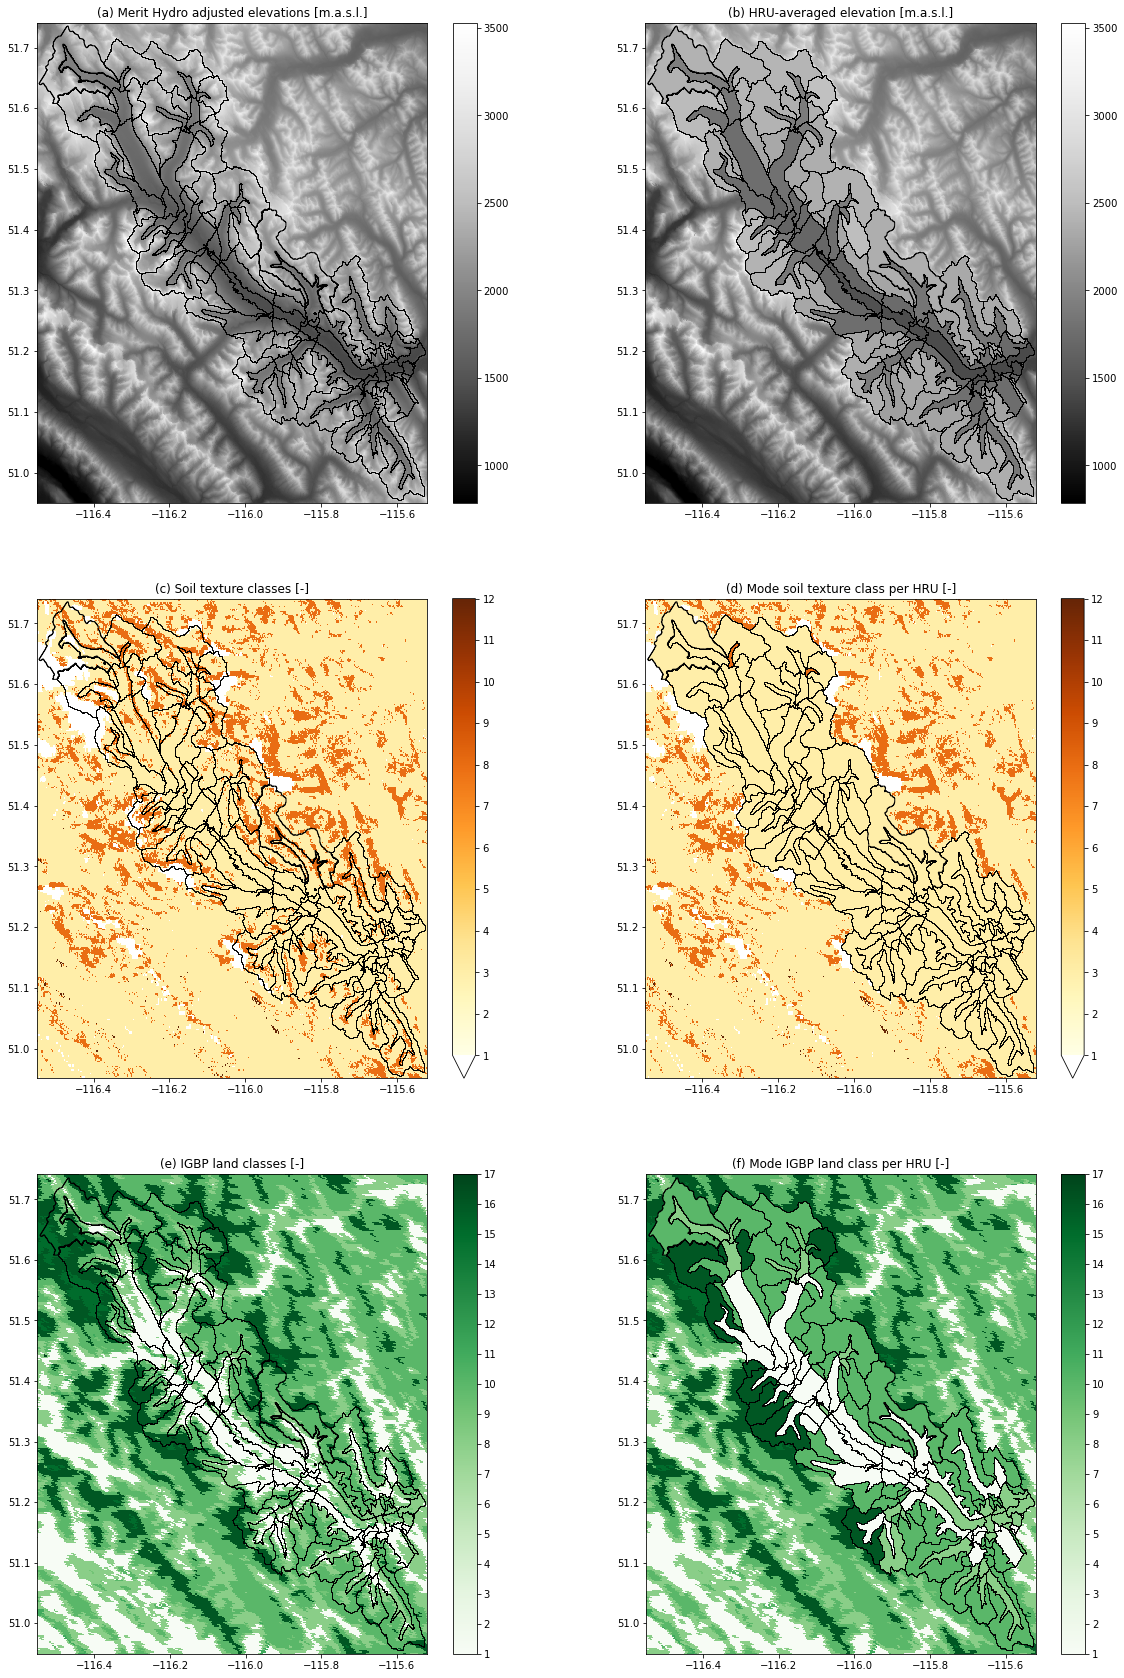

In [121]:
fig, axs = plt.subplots(3,2,figsize=(20,30))
axs = axs.flatten()

# --- DEM
# source data + catchment
axId = 0
dem.sel(band=1).plot(cmap=cmap_dem, ax=axs[axId], vmin=vmin_dem,vmax=vmax_dem)
catchment.plot(color='None', edgecolor='k', ax=axs[axId]);
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
axs[axId].set_title('(a) Merit Hydro adjusted elevations [m.a.s.l.]')

# source data + HRU mean
axId = 1
dem.sel(band=1).plot(cmap=cmap_dem, ax=axs[axId], vmin=vmin_dem, vmax=vmax_dem)
catchment.plot(column='plot_elev', edgecolor='k', ax=axs[axId], cmap=cmap_dem, vmin=vmin_dem, vmax=vmax_dem);
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
axs[axId].set_title('(b) HRU-averaged elevation [m.a.s.l.]')

# --- Soil
# source data + catchment
axId = 2
h = soil.sel(band=1).plot(cmap=cmap_soil, ax=axs[axId], vmin=vmin_soil, vmax=vmax_soil)
catchment.plot(color='None', edgecolor='k', ax=axs[axId]);
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
axs[axId].set_title('(c) Soil texture classes [-]')
h.colorbar.set_ticks(ticks_soil)

# source data + HRU mean
axId = 3
h = soil.sel(band=1).plot(cmap=cmap_soil, ax=axs[axId], vmin=vmin_soil, vmax=vmax_soil)
catchment.plot(column='plot_soil', edgecolor='k', ax=axs[axId], cmap=cmap_soil, vmin=vmin_soil, vmax=vmax_soil);
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
axs[axId].set_title('(d) Mode soil texture class per HRU [-]')
h.colorbar.set_ticks(ticks_soil)


# --- land
# source data + catchment
axId = 4
h = land.sel(band=1).plot(cmap=cmap_land, ax=axs[axId], vmin=vmin_land, vmax=vmax_land)
catchment.plot(color='None', edgecolor='k', ax=axs[axId]);
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
axs[axId].set_title('(e) IGBP land classes [-]')
h.colorbar.set_ticks(ticks_land)

# source data + HRU mean
axId = 5
h = land.sel(band=1).plot(cmap=cmap_land, ax=axs[axId], vmin=vmin_land, vmax=vmax_land)
catchment.plot(column='plot_land', edgecolor='k', ax=axs[axId], cmap=cmap_land, vmin=vmin_land, vmax=vmax_land);
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
axs[axId].set_title('(f) Mode IGBP land class per HRU [-]')
h.colorbar.set_ticks(ticks_land)

# save
plt.savefig(fig_path/fig_name, bbox_inches='tight')